In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [3]:
fight_data = pd.read_csv('cleaned_ufc_fight_data.csv')
fight_stat_data = pd.read_csv('cleaned_ufc_fight_stat_data.csv')
fighter_data = pd.read_csv('cleaned_ufc_fighter_data.csv')
event_data = pd.read_csv('cleaned_ufc_event_data.csv')

# Data Analysis

### Knockdowns vs. Win Ratios

Goal: Look at the relationship between the number of knockdowns and the likeliood of winning the fight.

1. Step 1: Data Prep:
    - Filter rows that have non-null values for knowndowns and fighter_id in fight_stat_data
    - Merge filtered fight_stat_data with fight_data to get info about which fighter won for each fight (winner) 
    
2. Step 2: Calculate KD and Win outcome:
    - Group merged data by fighter_id
    - Calculate total number of KD and total number of wins for each fighter.
    - Calculate how many fights each fighter won, (fighter_id, winner, fight_data) 
    
3. Step 3: Calculate win ratios: 
    - total wins / total fights
    - Seperate fighters into categories based on KD 
    - Get the average win ratio for each KD category

4. Visualization:
    - Create a bar chart to comapre the average win ratio for each KD category
    
5. Insights:
    - Anayse the graph to see if there is a trend between KD and win ratios.
    - See if the differences are statistically significant (maybe chi-sqauare test)

In [10]:
filtered_stats = fight_stat_data.dropna(subset=['knockdowns', 'fighter_id'])

In [11]:
merged_data = filtered_stats.merge(fight_data, how='left', left_on='fight_id', right_on='fight_id')

### Knockdowns and Win Outcome

In [12]:
merged_data['is_winner'] = merged_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)
grouped_data = merged_data.groupby('fighter_id').agg(
    total_knockdowns=('knockdowns', 'sum'),
    total_fights=('fight_id', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()


In [13]:
grouped_data['win_ratio'] = grouped_data['total_wins'] / grouped_data['total_fights']

In [14]:
knockdown_bins = [0, 1, 3, float('inf')]
knockdown_labels = ['0-1', '2-3', '4+']
grouped_data['knockdown_category'] = pd.cut(grouped_data['total_knockdowns'], bins=knockdown_bins, labels=knockdown_labels)

In [15]:
grouped_data['win_ratio'] = grouped_data['total_wins'] / grouped_data['total_fights']


In [16]:
knockdown_bins = [0, 1, 3, float('inf')]
knockdown_labels = ['0-1', '2-3', '4+']
grouped_data['knockdown_category'] = pd.cut(grouped_data['total_knockdowns'], bins=knockdown_bins, labels=knockdown_labels)

In [17]:
knockdown_vs_win_ratio = grouped_data.groupby('knockdown_category')['win_ratio'].mean().reset_index()

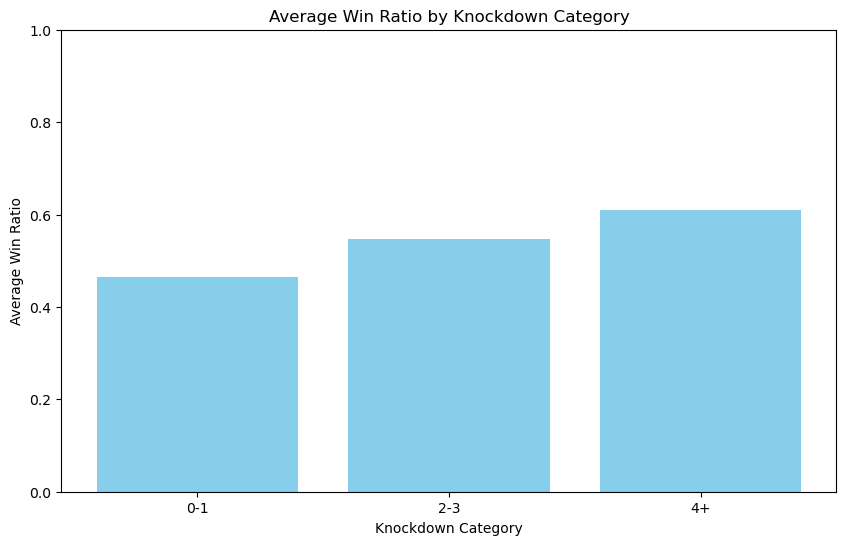

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(knockdown_vs_win_ratio['knockdown_category'], knockdown_vs_win_ratio['win_ratio'], color='skyblue')
plt.xlabel('Knockdown Category')
plt.ylabel('Average Win Ratio')
plt.title('Average Win Ratio by Knockdown Category')
plt.ylim(0, 1)
plt.show()

In [19]:
contingency_table = pd.crosstab(grouped_data['knockdown_category'], grouped_data['total_wins'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [20]:
print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")

Chi-square test statistic: 453.7118406358914
P-value: 1.9664049913851846e-67


### Insights: 

**Knockdowns as a Success Predictor:** As evidenced by the much greater success rates of fighters with more knockdowns, especially 4+, knockdowns are a powerful predictor of battle outcomes.

**Strategic Implications:** Prioritizing strategies that increase knockdown potential may be advantageous given the strong association between winning and knockdowns.

**Statistical Significance:** With a relatively low p-value, the chi-square test result shows that the observed variations in victory ratios between knockdown categories are statistically significant. This supports the idea that knockdowns have a significant impact on winning since it indicates that the correlation between knockdowns and win rates is unlikely to be the result of chance.

Given that boxers with four or more knockdowns have notably greater victory rates, the threshold effect identifies a point at which knockdowns may signify dominant performance.






### How do fight outcomes differ based on stances like Orthodox, Southpaw, and Switch?  

1. Merge relevant data from the datatsets
2. Aggregate data by stance
3. Visualize

In [21]:
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')

In [22]:
full_data['is_winner'] = full_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)


In [23]:
stance_analysis = full_data.groupby('fighter_stance').agg(
    total_fights=('fight_id', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()


In [24]:
stance_analysis['win_ratio'] = stance_analysis['total_wins'] / stance_analysis['total_fights']


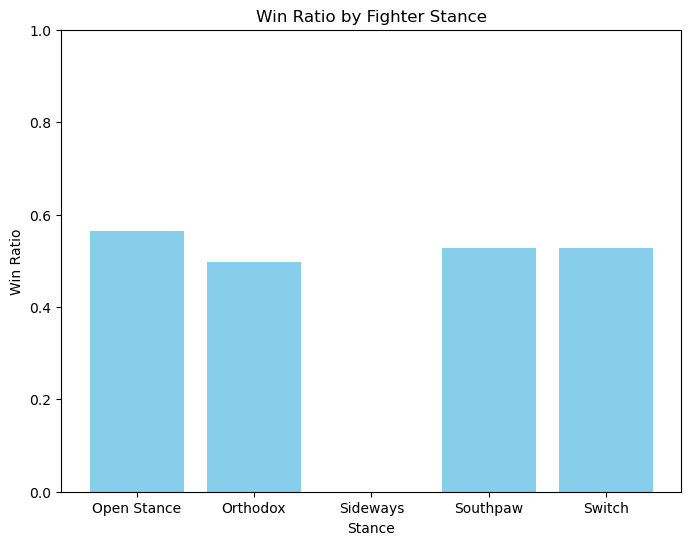

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(stance_analysis['fighter_stance'], stance_analysis['win_ratio'], color='skyblue')
plt.xlabel('Stance')
plt.ylabel('Win Ratio')
plt.title('Win Ratio by Fighter Stance')
plt.ylim(0, 1)
plt.show()

In [26]:
print(stance_analysis)

  fighter_stance  total_fights  total_wins  win_ratio
0    Open Stance            23          13   0.565217
1       Orthodox         10555        5252   0.497584
2       Sideways             1           0   0.000000
3       Southpaw          2780        1468   0.528058
4         Switch           673         355   0.527489


### Insights: 

According to the data, fighters who adopt the Southpaw and Switch stances had somewhat greater victory percentages than Orthodox fighters, which may indicate that these less popular stances provide a tactical edge. Despite being the most common viewpoint, orthodoxy has a lower success percentage, maybe because it is predictable. Though less frequent, the Open Stance also has a comparatively high victory rate. This implies that different stances could affect how a battle turns out, providing fighters who want to improve their performance by changing their stance some knowledge.


### What impact does age have on a fighter’s success, especially comparing fighters under 20 vs. over 20?  

1. Classify fighters into age groups
2. Calculate win ratios
3. Visualize

In [27]:
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')
full_data = full_data.merge(event_data[['event_id', 'event_date']], how='left', on='event_id')


In [28]:
full_data['fighter_dob'] = pd.to_datetime(full_data['fighter_dob'], errors='coerce')
full_data['event_date'] = pd.to_datetime(full_data['event_date'], errors='coerce')


In [29]:
full_data['age_at_fight'] = (full_data['event_date'] - full_data['fighter_dob']).dt.days / 365.25

full_data['age_group'] = full_data['age_at_fight'].apply(lambda x: 'Under 20' if x < 20 else 'Over 20')
full_data['is_winner'] = full_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)


In [30]:
age_analysis = full_data.groupby('age_group').agg(
    total_fights=('fight_id', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()


In [31]:
age_analysis['win_ratio'] = age_analysis['total_wins'] / age_analysis['total_fights']


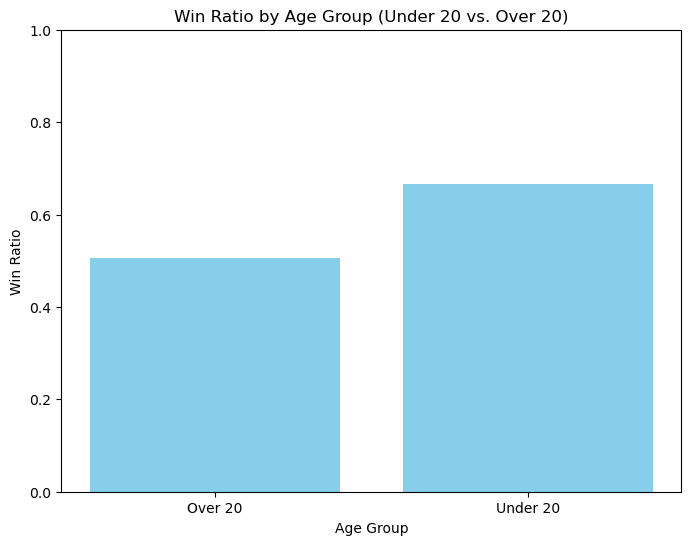

In [32]:
plt.figure(figsize=(8, 6))
plt.bar(age_analysis['age_group'], age_analysis['win_ratio'], color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Win Ratio')
plt.title('Win Ratio by Age Group (Under 20 vs. Over 20)')
plt.ylim(0, 1)
plt.show()

In [33]:
print(age_analysis)

  age_group  total_fights  total_wins  win_ratio
0   Over 20         14020        7080   0.504993
1  Under 20            12           8   0.666667


### Insights: 

Although the sample size for fighters under 20 is much less, the research reveals that their victory ratio is greater (66.7%) than that of fighters over 20 (50.5%). This implies that although younger competitors could have an advantage, conclusions should be read cautiously because there is little data for under-20 combatants. This data could suggest that younger combatants have an edge in agility or resilience, but more research with a bigger sample size would be helpful.


### splitting age groups into 10 equal buckets to tell if age has an impact on win ratio

1. Classify fighters into age groups
2. Calculate win ratios
3. Visualize

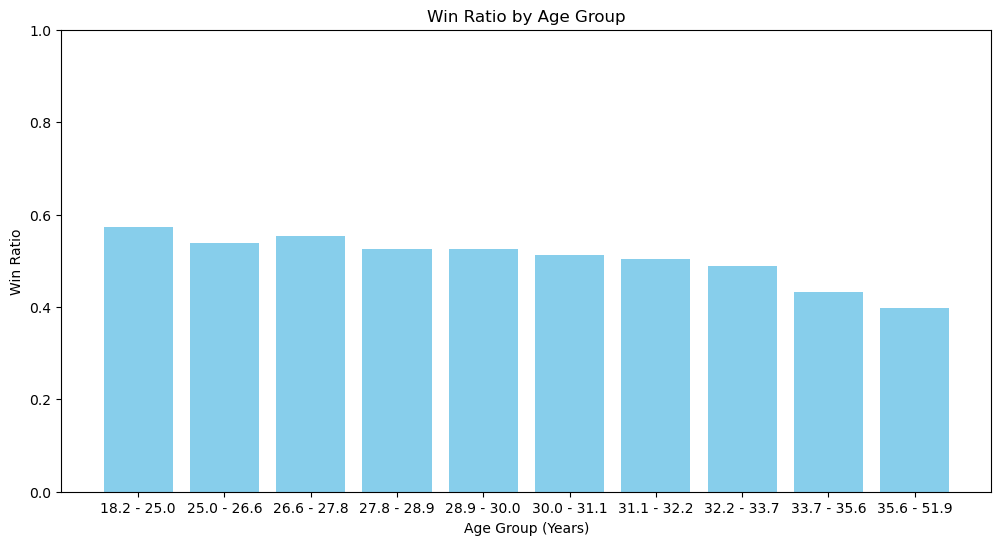

In [34]:
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')
full_data = full_data.merge(event_data[['event_id', 'event_date']], how='left', on='event_id')
full_data['fighter_dob'] = pd.to_datetime(full_data['fighter_dob'], errors='coerce')
full_data['event_date'] = pd.to_datetime(full_data['event_date'], errors='coerce')
full_data['age_at_fight'] = (full_data['event_date'] - full_data['fighter_dob']).dt.days / 365.25

#split into 10 equal age groups
age_groups = pd.qcut(full_data['age_at_fight'], q=10)
full_data['age_group'] = age_groups.apply(lambda x: f"{x.left:.1f} - {x.right:.1f}")
full_data['is_winner'] = full_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)

age_analysis = full_data.groupby('age_group').agg(
    total_fights=('fight_id', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()

age_analysis['win_ratio'] = age_analysis['total_wins'] / age_analysis['total_fights']

plt.figure(figsize=(12, 6))
plt.bar(age_analysis['age_group'], age_analysis['win_ratio'], color='skyblue')
plt.xlabel('Age Group (Years)')
plt.ylabel('Win Ratio')
plt.title('Win Ratio by Age Group')
plt.ylim(0, 1)
plt.show()

### are the win ratios between each bucket significantly different? Using ANOVA

In [35]:
age_groups_data = full_data.groupby('age_group').apply(lambda x: x['is_winner']).reset_index(level=0)
age_group_win_ratios = [group_data.tolist() for name, group_data in age_groups_data.groupby('age_group')['is_winner']]
f_stat, p_value = stats.f_oneway(*age_group_win_ratios)

# Display results
print("ANOVA test results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The difference in win ratios between age groups is statistically significant (p < 0.05).")
else:
    print("There is no statistically significant difference in win ratios between age groups (p >= 0.05).")

ANOVA test results:
F-statistic: 16.3990
P-value: 0.0000
The difference in win ratios between age groups is statistically significant (p < 0.05).


### Insights
This shows a very gradual trend of younger fighters having a higher win ratio than older fighters. However, the difference is very little, but drops very quickly once a fighter reaches their mid 30's. We can also see that range of each bucket increase, showing there are very few fighters that fight after their mid 30's. However, the diference in age groups is statistically significant according to the ANOVA calculations, meaning that fighter age does impact win ratio. Therefore, fighters in the age range of 18-25 have the highest Win Ratios. This could be attributed to their youth, or becuase only really skilled young fighters get to compete at this level, inflating their win ratio compared to older fighters.


### Fighters performance over time

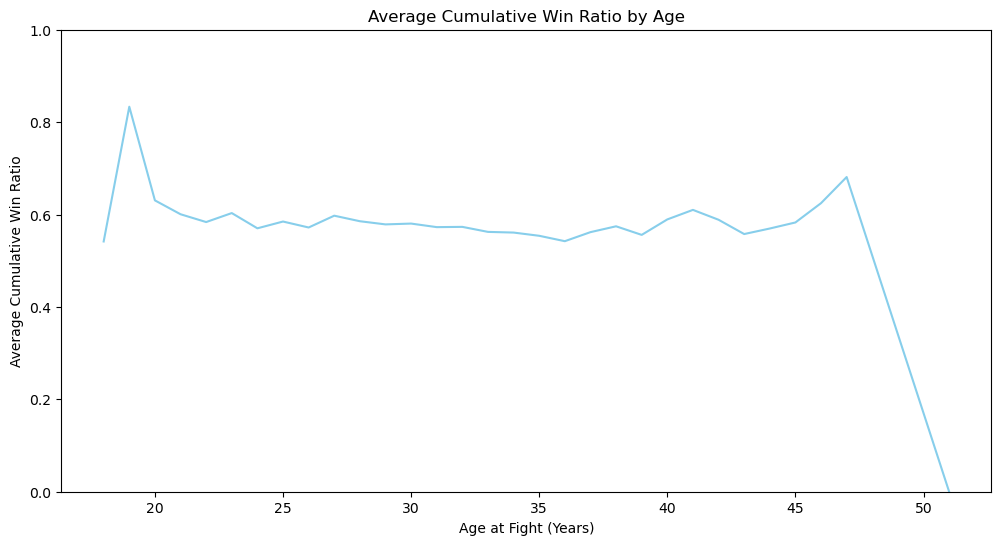

In [36]:
# Merging the data as before
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')
full_data = full_data.merge(event_data[['event_id', 'event_date']], how='left', on='event_id')

# Convert dates to datetime format
full_data['fighter_dob'] = pd.to_datetime(full_data['fighter_dob'], errors='coerce')
full_data['event_date'] = pd.to_datetime(full_data['event_date'], errors='coerce')

# Calculate the age of the fighter at each fight
full_data['age_at_fight'] = (full_data['event_date'] - full_data['fighter_dob']).dt.days / 365.25

# Determine if each fight is a win for the fighter
full_data['is_winner'] = full_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)

# Sort by fighter and event date to track performance over time
full_data = full_data.sort_values(by=['fighter_id', 'event_date'])

# Calculate cumulative wins and cumulative fights for each fighter over time
full_data['cumulative_wins'] = full_data.groupby('fighter_id')['is_winner'].cumsum()
full_data['cumulative_fights'] = full_data.groupby('fighter_id').cumcount() + 1
full_data['cumulative_win_ratio'] = full_data['cumulative_wins'] / full_data['cumulative_fights']

# Bin ages into 1-year intervals and calculate the average cumulative win ratio for each age bin
full_data['age_bin'] = full_data['age_at_fight'].apply(lambda x: int(x))  # Create integer age bins
age_analysis = full_data.groupby('age_bin').agg(
    average_cumulative_win_ratio=('cumulative_win_ratio', 'mean')
).reset_index()

# Plotting the average cumulative win ratio by age
plt.figure(figsize=(12, 6))
plt.plot(age_analysis['age_bin'], age_analysis['average_cumulative_win_ratio'], color='skyblue')
plt.xlabel('Age at Fight (Years)')
plt.ylabel('Average Cumulative Win Ratio')
plt.title('Average Cumulative Win Ratio by Age')
plt.ylim(0, 1)
plt.show()

### Insights
It is easy to see that once again win ratios spike at a young age. Win ratios stabilize and then gradually decline through the 20s and 30s, possibly due to tougher competition and physical wear.. This could be due to most fighters retiring in their early 30's when they are past their prime, and the only fighters left figting at the older ages are ones that are really good. These older fighters represent the Elite, durable athletes with the most fight expierence. The sharp drop off after 45 is from a lack of sample size, showing all fighters in this data set retire before they are 48.

### How do strike patterns differ across various weight divisions and genders?

1. Classify Strikes (attempted and successful)
2. Calculate average strike accuracy
3. Visualize

In [37]:
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')
full_data = full_data.merge(event_data[['event_id', 'event_date']], how='left', on='event_id')

In [38]:
full_data['total_strike_accuracy'] = full_data['total_strikes_succ'] / full_data['total_strikes_att']
full_data['sig_strike_accuracy'] = full_data['sig_strikes_succ'] / full_data['sig_strikes_att']

In [39]:
strike_analysis = full_data.groupby(['weight_class', 'gender']).agg(
    avg_total_strike_accuracy=('total_strike_accuracy', 'mean'),
    avg_sig_strike_accuracy=('sig_strike_accuracy', 'mean')
).reset_index()

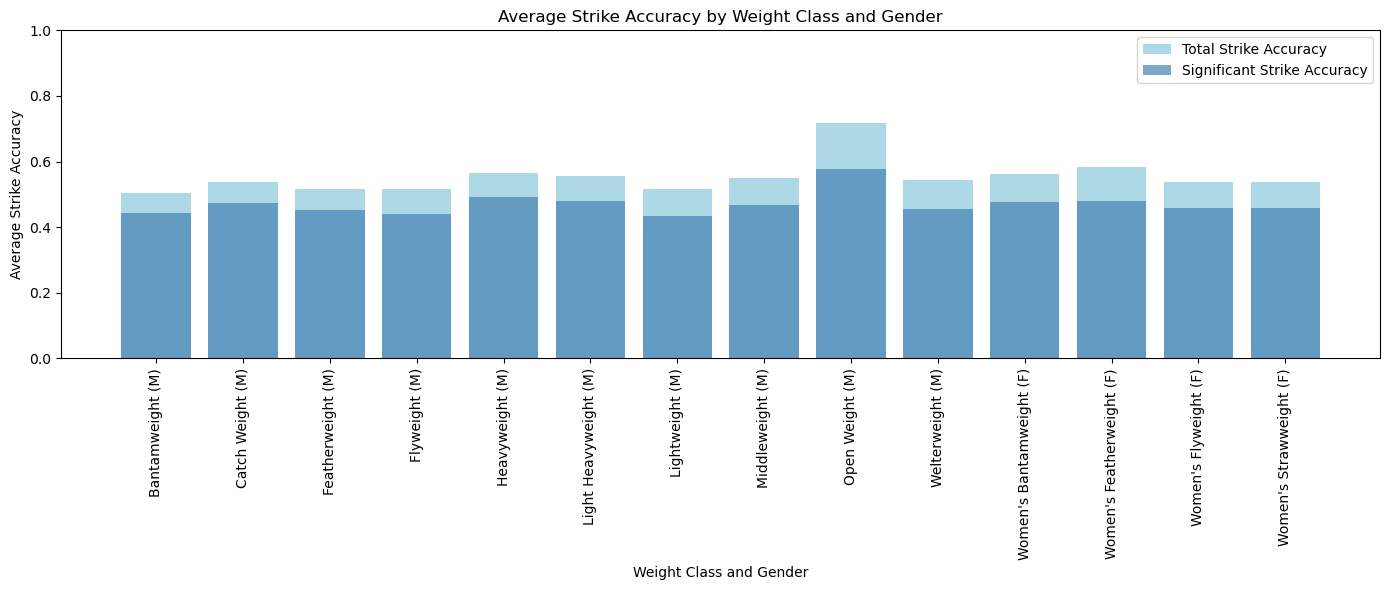

In [40]:
plt.figure(figsize=(14, 6))
plt.bar(strike_analysis['weight_class'] + ' (' + strike_analysis['gender'] + ')', 
        strike_analysis['avg_total_strike_accuracy'], color='lightblue', label='Total Strike Accuracy')
plt.bar(strike_analysis['weight_class'] + ' (' + strike_analysis['gender'] + ')', 
        strike_analysis['avg_sig_strike_accuracy'], color='steelblue', alpha=0.7, label='Significant Strike Accuracy')

plt.xlabel('Weight Class and Gender')
plt.ylabel('Average Strike Accuracy')
plt.title('Average Strike Accuracy by Weight Class and Gender')
plt.xticks(rotation=90)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [41]:
print(strike_analysis)

             weight_class gender  avg_total_strike_accuracy  \
0            Bantamweight      M                   0.504518   
1            Catch Weight      M                   0.537489   
2           Featherweight      M                   0.515902   
3               Flyweight      M                   0.516661   
4             Heavyweight      M                   0.563712   
5       Light Heavyweight      M                   0.554698   
6             Lightweight      M                   0.515309   
7            Middleweight      M                   0.549846   
8             Open Weight      M                   0.717306   
9            Welterweight      M                   0.542491   
10   Women's Bantamweight      F                   0.561209   
11  Women's Featherweight      F                   0.582252   
12      Women's Flyweight      F                   0.536276   
13    Women's Strawweight      F                   0.536282   

    avg_sig_strike_accuracy  
0                  0.444

### Insights

The current research points out a large discrepancy in the striking accuracy with regard to both gender and weight class. Male fighters appear to do better in heavier weight classes, such as Heavyweight and Light Heavyweight, while females perform somewhat better in lighter weight classes, such as Women's Featherweight. Interestingly enough, total accuracy was the highest among them all in the odd Open Weight class. Since the fact remains that larger divisions and some of the women's weight classes do stick out for their preciseness, it goes to show that gender and weight class could affect striking success.


### Most common Win Method

Most common result detail:
result_detail    Unanimous
count                 2557
Name: 0, dtype: object

Top 10 most common result details:
                       result_detail  count
0                          Unanimous   2557
1                              Split    679
2          Punch to Head At Distance    612
3                   Rear Naked Choke    533
4        Punches to Head At Distance    307
5          Punches to Head On Ground    210
6            Punch to Head In Clinch    125
7           Kick to Head At Distance    103
8         Punches to Head From Mount    102
9  Punches to Head From Back Control     88


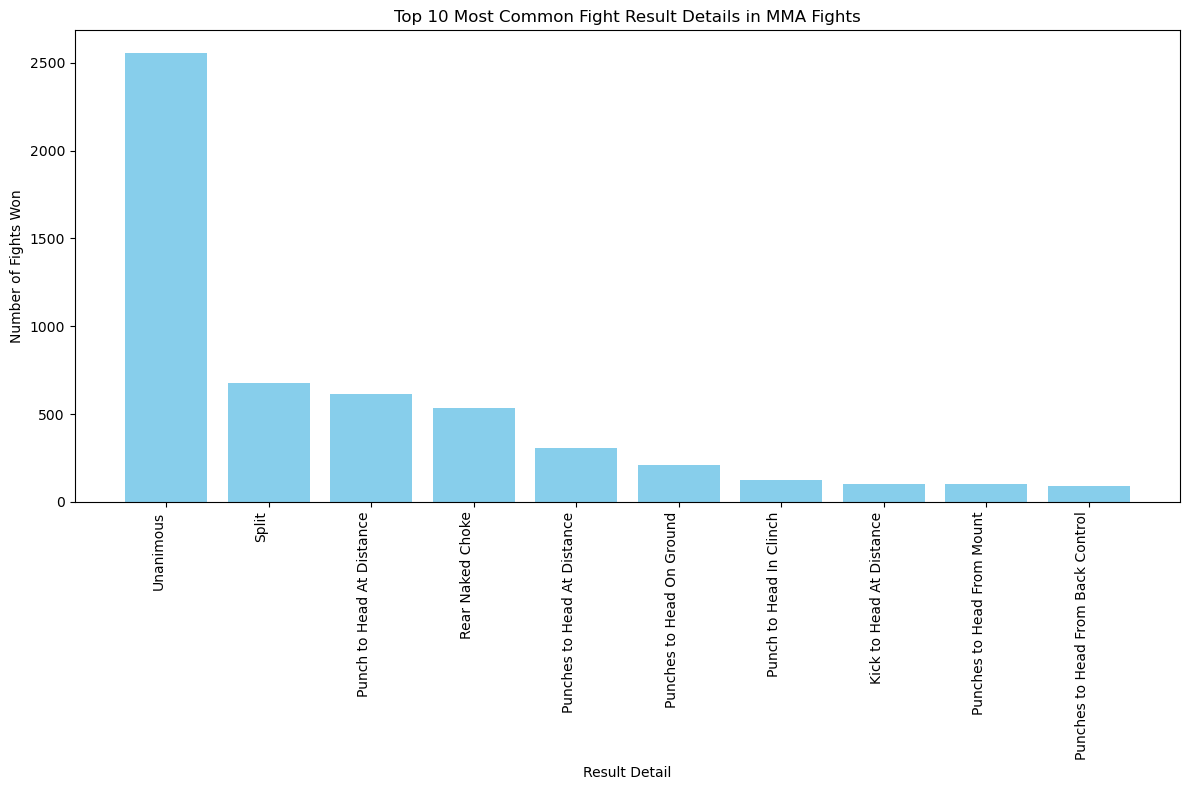

In [42]:
result_detail_counts = fight_data['result_details'].value_counts().reset_index()
result_detail_counts.columns = ['result_detail', 'count']

# Display the most common result detail
most_common_result = result_detail_counts.iloc[0]
print("Most common result detail:")
print(most_common_result)

# Display the top 10 result details
print("\nTop 10 most common result details:")
print(result_detail_counts.head(10))

top_10_result_detail_counts = result_detail_counts.head(10)

# Plotting the top 10 result details by count
plt.figure(figsize=(12, 8))
plt.bar(top_10_result_detail_counts['result_detail'], top_10_result_detail_counts['count'], color='skyblue')
plt.xlabel('Result Detail')
plt.ylabel('Number of Fights Won')
plt.title('Top 10 Most Common Fight Result Details in MMA Fights')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

### Insights
Disregarding outcomes that are unaminous or split, We can see that strikes to the head are often impactful on the outcome of the fight in comparison with submission strategies like chokes. We can also see that the rear naked choke is often a match deciding move, which means fighters should prioritize this choke, as well as landing hits to the head.

Also shows that the vast majority of fights are won by judges decisions, not knockout or submission. As such, elements that improve judge score should be prioritized over mvoes that aim for a KO. These include things like strike effectiveness, strike power, and strike accuracy, as well as ground control(unfortunately we have no data for this). 

### Analysizing physical features and fight success

Correlation Matrix:
                    fighter_height_cm  fighter_weight_lbs  fighter_reach_cm  \
fighter_height_cm            1.000000            0.739597          0.887676   
fighter_weight_lbs           0.739597            1.000000          0.752433   
fighter_reach_cm             0.887676            0.752433          1.000000   
win_ratio                   -0.062134           -0.179155          0.043639   

                    win_ratio  
fighter_height_cm   -0.062134  
fighter_weight_lbs  -0.179155  
fighter_reach_cm     0.043639  
win_ratio            1.000000  


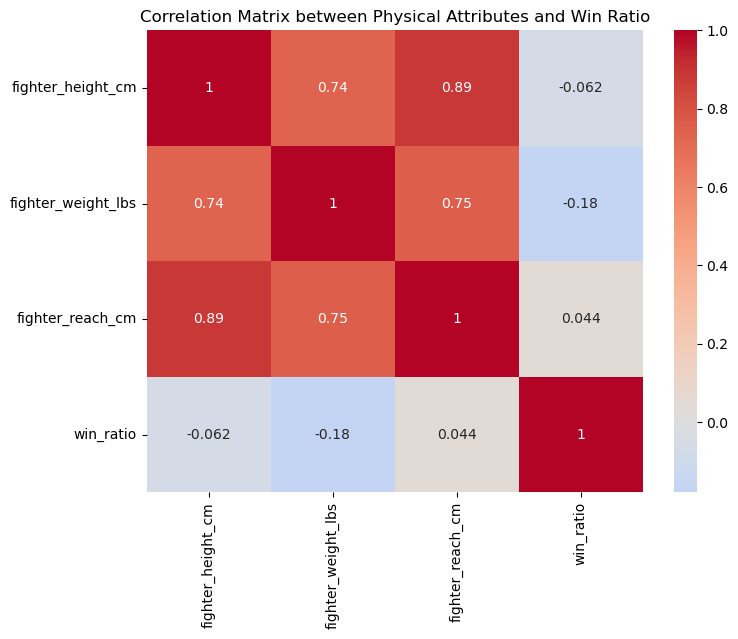

In [43]:
fighter_data['win_ratio'] = fighter_data['fighter_w'] / (fighter_data['fighter_w'] + fighter_data['fighter_l'])

# Select relevant columns for correlation analysis
attributes_data = fighter_data[['fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm', 'win_ratio']]

# Calculate correlation matrix and display it
correlation_matrix = attributes_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plotting the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Matrix between Physical Attributes and Win Ratio')
plt.show()

### Insights
This heat map tells us that there is a strong correlation of fighter reach and fighter height, which is to be expected. It also tells us that fighter weight and fighter height are correlated, meaning that taller fighters tend to fight in heavier weight classes. Fighter weight is also positively correlated with fighter read, which is to be expected given that heavier fighters tend to be taller. We can also see that fighter hieght, fighter reach, and fighter_weight are not strongly correlated to win_ratio. This may be becuase all of the fighters in MMA are competing at the top level, and as such either are very similar in body composition given their weight class, or that they have overcome not having an ideal compisition via technique. This also reienforces that winning MMA fights depends on a very wide range of variables. Having fighter reach not be super correlated with win_ratio was slightly surprising though.

### Cluster Analysis for Fighter Physical Features
Use kmeans cluster analysis

In [4]:
# Select the physical attributes for clustering and drop missing values
clustering_data = fighter_data[['fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm', 'win_ratio']].dropna()

# Standardize the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data[['fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm']])

# Determine optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve for Optimal Number of Clusters')
plt.show()

# Choose the optimal number of clusters (e.g., k=3 based on the elbow plot) and fit KMeans
optimal_k = 3  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_data['cluster'] = kmeans.fit_predict(scaled_data)
#calculate average physical attributes for each cluster
cluster_attributes = clustering_data.groupby('cluster')[['fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm']].mean()
print("Average physical attributes for each cluster:")
print(cluster_attributes)

# Manually inspect `cluster_attributes` to assign descriptive labels based on average values
# Example label assignment (adjust as needed based on your actual data interpretation)
cluster_labels = {
    0: 'average height, average weight, average reach ',
    1: 'small height, low weight, low reach',
    2: 'Tall, heavy, and long reach'
}

# Map cluster numbers to descriptive labels
clustering_data['cluster_label'] = clustering_data['cluster'].map(cluster_labels)

# Calculate the average win ratio for each descriptive cluster label
cluster_analysis = clustering_data.groupby('cluster_label')['win_ratio'].mean().reset_index()

# Plot the average win ratio for each descriptive cluster label
plt.figure(figsize=(16, 16))
sns.barplot(x='cluster_label', y='win_ratio', data=cluster_analysis, palette="viridis")
plt.xlabel('Physical Attribute Cluster')
plt.ylabel('Average Win Ratio')
plt.title('Average Win Ratio by Physical Attribute Cluster')
plt.show()

KeyError: "['win_ratio'] not in index"

### Insights
This cluster analysis once again shows that fighter hieght, fighter reach, and fighter weight do not have a significant influence on win ratio, as they are roughly the same. This once again shows that in MMA, fighter physical features do not impact fight result. It also shows that MMA matchmaking and weight classes do a very good job at making sure everything is fair.

### Classification method for fighters based on strikes
1. Use a logistic Regression
2. Use a Decision tree classifier

/tmp/ipykernel_134/1068262876.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'event_date_x'} in the result is deprecated and will raise a MergeError in a future version.
  fight_data = fight_data.merge(


NaN values found in X. Filling with 0.
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       693
           1       0.91      0.82      0.86      1280

    accuracy                           0.83      1973
   macro avg       0.81      0.83      0.82      1973
weighted avg       0.84      0.83      0.83      1973

Logistic Regression Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       693
           1       0.90      0.82      0.86      1280

    accuracy                           0.83      1973
   macro avg       0.81      0.83      0.82      1973
weighted avg       0.84      0.83      0.83      1973

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       693
           1       0.90      0.79      0.84      1280

    acc

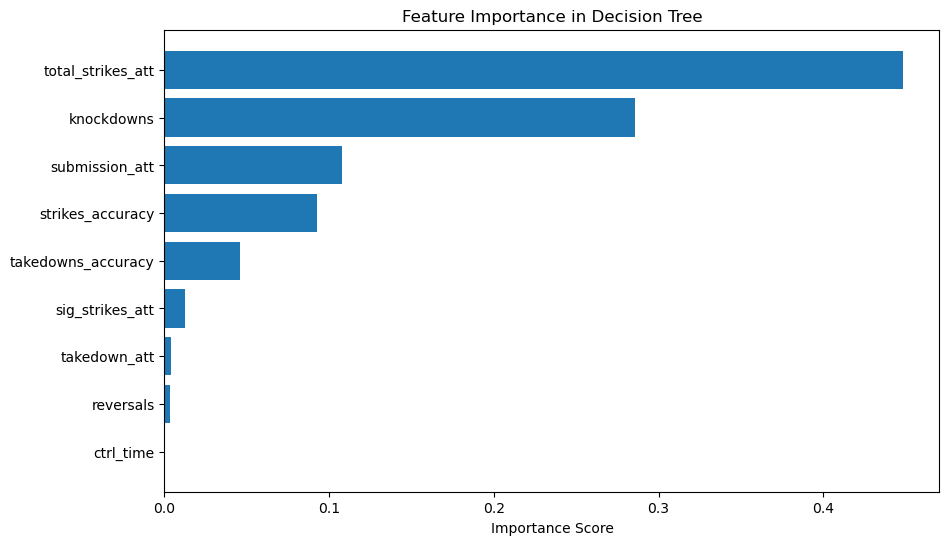

In [50]:
# Step 1: Calculate accuracy for strikes and takedowns in fight_stat_data
fight_stat_data['strikes_accuracy'] = fight_stat_data['total_strikes_succ'] / fight_stat_data['total_strikes_att']
fight_stat_data['takedowns_accuracy'] = fight_stat_data['takedown_succ'] / fight_stat_data['takedown_att']
fight_stat_data = fight_stat_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
fight_stat_data[['strikes_accuracy', 'takedowns_accuracy']] = fight_stat_data[['strikes_accuracy', 'takedowns_accuracy']].fillna(0)

# Step 2: Merge fight_data with event_data to get event_date
fight_data = fight_data.merge(
    event_data[['event_id', 'event_date']],
    on='event_id', how='left'
)

# Step 3: Join Fighter Stats (f_1 and f_2) with fight_data
fighter_stats_columns = ['knockdowns', 'total_strikes_att', 
                         'sig_strikes_att', 'takedown_att', 
                        'submission_att', 'reversals', 
                         'ctrl_time', 'strikes_accuracy', 'takedowns_accuracy']

# Fighter 1 (f_1)
merged_f1 = fight_data.merge(
    fight_stat_data[['fight_id', 'fighter_id'] + fighter_stats_columns],
    left_on=['fight_id', 'f_1'], right_on=['fight_id', 'fighter_id'], suffixes=('', '_f1')
).drop(columns=['fighter_id'])  # Drop redundant fighter_id column

# Rename columns for Fighter 1 (f_1) statistics only
merged_f1 = merged_f1.rename(columns=lambda x: x + '_f1' if x in fighter_stats_columns else x)

# Fighter 2 (f_2)
merged_data = merged_f1.merge(
    fight_stat_data[['fight_id', 'fighter_id'] + fighter_stats_columns],
    left_on=['fight_id', 'f_2'], right_on=['fight_id', 'fighter_id'], suffixes=('', '_f2')
).drop(columns=['fighter_id'])  # Drop redundant fighter_id column

# Rename columns for Fighter 2 (f_2) statistics only
merged_data = merged_data.rename(columns=lambda x: x + '_f2' if x in fighter_stats_columns else x)

# Step 4: Feature Engineering - Calculate Differences Between Fighter 1 and Fighter 2
features_f1 = [f + '_f1' for f in fighter_stats_columns]
features_f2 = [f + '_f2' for f in fighter_stats_columns]

# Compute the difference between each fighter's stats as features
X = merged_data[features_f1].values - merged_data[features_f2].values
y = (merged_data['winner'] == merged_data['f_1']).astype(int)  # 1 if Fighter 1 won, else 0

# Check for NaN values in X and handle them
if np.isnan(X).any():
    print("NaN values found in X. Filling with 0.")
    X = np.nan_to_num(X)  # Fill NaNs with 0 or use other imputation methods if needed

# Step 5: Outlier Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X)
X = X[outliers == 1]
y = y[outliers == 1]

# Step 6: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Logistic Regression
log_reg = LogisticRegression(max_iter=500, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, zero_division=0))

# Logistic Regression with SMOTE-applied data
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg_smote = log_reg.predict(X_test)
print("Logistic Regression Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_log_reg_smote, zero_division=0))

# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree, zero_division=0))

# Step 10: Feature Importance for Decision Tree
feature_importances = tree_clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': [col.replace('_f1', '') for col in features_f1],  # Just show feature names without suffix
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance in Decision Tree')
plt.xlabel('Importance Score')
plt.show()

### INsights
When successful strikes and successful signifant strikes are included, they are considered the most important attributes for winning a fight. Niether Logistic regression nor decision trees require scaled data, so no scaled data has been provided.
1. Logistic regression
    Precision, recall, and f-score are relatively balanced, and accuracy is relatively high. Shows a slight bias towards showing fighter 1 winning
2. Logistic Regreesion with SMOTE
    very similar to the standard logistic regression, implying the balanced weight of classes did its job properly
3. Decision Tree
    slightly less accurate than the logistic regressions, with worse precision, recall, and f-score than the logistic regressions implying that logistic regressions are a better classification strategy for this data.
4. Feature importance
    Total strike attempts is by far the most important feature in the decision tree, implying that being on the defensive is not a good strategy for MMA. Stike accuracy is also very important, as well as submission attempts, supporting that being on the offensive is a good strategy for MMA.

In [13]:
# Load datasets

# Merge fight_data with fight_stat_data for both fighters
f1_stats = fight_stat_data.rename(columns=lambda x: f"{x}_f1" if x != 'fight_id' else x)
f2_stats = fight_stat_data.rename(columns=lambda x: f"{x}_f2" if x != 'fight_id' else x)

merged_data = (
    fight_data
    .merge(f1_stats, left_on=['fight_id', 'f_1'], right_on=['fight_id', 'fighter_id_f1'])
    .merge(f2_stats, left_on=['fight_id', 'f_2'], right_on=['fight_id', 'fighter_id_f2'])
)

#print(list(merged_data.columns))

# Drop redundant columns
merged_data.drop(columns=['fighter_id_f1', 'fighter_id_f2'], inplace=True)
#print(list(merged_data.columns))

# Feature Engineering: Calculate hit rates for both fighters
for fighter in ['f1', 'f2']:
    merged_data[f'{fighter}_total_strike_hit_rate'] = merged_data[f'total_strikes_succ_{fighter}'] / \
                                                      (merged_data[f'total_strikes_att_{fighter}'] + 1e-9)
    merged_data[f'{fighter}_sig_strike_hit_rate'] = merged_data[f'sig_strikes_succ_{fighter}'] / \
                                                    (merged_data[f'sig_strikes_att_{fighter}'] + 1e-9)

#print(list(merged_data.columns))

# Define the target: Label 1 if f_1 is the winner, otherwise 0
merged_data['label'] = (merged_data['winner'] == merged_data['f_1']).astype(int)
#print(list(merged_data.columns))

# Select features for the model
features = [
    'knockdowns_f1', 'total_strikes_att_f1', 'total_strikes_succ_f1', 'sig_strikes_att_f1', 'sig_strikes_succ_f1', 'takedown_att_f1', 'submission_att_f1', 'f1_total_strike_hit_rate', 'f1_sig_strike_hit_rate',
    'knockdowns_f2', 'total_strikes_att_f2', 'total_strikes_succ_f2', 'sig_strikes_att_f2', 'sig_strikes_succ_f2', 'takedown_att_f2', 'submission_att_f2', 'f2_total_strike_hit_rate', 'f2_sig_strike_hit_rate']
X = merged_data[features]
y = merged_data['label']
smote = SMOTE
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))
# Train the RandomForestClassifier on resampled data
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=10, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean CV Accuracy: {scores.mean()}")

Before SMOTE: Counter({1: 3606, 0: 1930})
After SMOTE: Counter({1: 3606, 0: 3606})
Accuracy: 0.855595667870036
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       514
           1       0.90      0.87      0.88       871

    accuracy                           0.86      1385
   macro avg       0.84      0.85      0.85      1385
weighted avg       0.86      0.86      0.86      1385

                     Feature  Importance
0              knockdowns_f1    0.124449
17    f2_sig_strike_hit_rate    0.104606
2      total_strikes_succ_f1    0.091653
6          submission_att_f1    0.077767
7   f1_total_strike_hit_rate    0.071598
13       sig_strikes_succ_f2    0.066741
11     total_strikes_succ_f2    0.064732
8     f1_sig_strike_hit_rate    0.052997
4        sig_strikes_succ_f1    0.052662
1       total_strikes_att_f1    0.050035
9              knockdowns_f2    0.049388
16  f2_total_strike_hit_rate    0.040916
10    

In [16]:

# Assuming fight_data and fight_stat_data are loaded as DataFrames
# Merge fight_data with fight_stat_data for both fighters
f1_stats = fight_stat_data.rename(columns=lambda x: f"{x}_f1" if x != 'fight_id' else x)
f2_stats = fight_stat_data.rename(columns=lambda x: f"{x}_f2" if x != 'fight_id' else x)

merged_data = (
    fight_data
    .merge(f1_stats, left_on=['fight_id', 'f_1'], right_on=['fight_id', 'fighter_id_f1'])
    .merge(f2_stats, left_on=['fight_id', 'f_2'], right_on=['fight_id', 'fighter_id_f2'])
)

# Drop redundant columns
merged_data.drop(columns=['fighter_id_f1', 'fighter_id_f2'], inplace=True)

# Feature Engineering: Calculate hit rates for both fighters
for fighter in ['f1', 'f2']:
    merged_data[f'total_strike_hit_rate_{fighter}'] = merged_data[f'total_strikes_succ_{fighter}'] / \
                                                      (merged_data[f'total_strikes_att_{fighter}'] + 1e-9)
    merged_data[f'sig_strike_hit_rate_{fighter}'] = merged_data[f'sig_strikes_succ_{fighter}'] / \
                                                    (merged_data[f'sig_strikes_att_{fighter}'] + 1e-9)

# Define the target: Label 1 if f_1 is the winner, otherwise 0
merged_data['label'] = (merged_data['winner'] == merged_data['f_1']).astype(int)
print("Columns in merged_data:", merged_data.columns)

# Duplicate and swap f_1 and f_2 in the data
swapped_data = merged_data.copy()

# Swap features of f_1 and f_2 using the updated column names
for feature in ['knockdowns', 'total_strikes_att', 'total_strikes_succ', 'sig_strikes_att', 'sig_strikes_succ',
                'takedown_att', 'submission_att', 'total_strike_hit_rate', 'sig_strike_hit_rate']:
    swapped_data[f'{feature}_f1'], swapped_data[f'{feature}_f2'] = (
        swapped_data[f'{feature}_f2'], swapped_data[f'{feature}_f1']
    )

# Adjust the label: If f_1 was the winner, f_2 is now the winner
swapped_data['label'] = 1 - swapped_data['label']

# Combine the original and swapped data
augmented_data = pd.concat([merged_data, swapped_data], ignore_index=True)

# Select features for the model
features = [
      'knockdowns_f1', 'total_strikes_att_f1', 'total_strikes_succ_f1', 'sig_strikes_att_f1', 'sig_strikes_succ_f1', 'takedown_att_f1', 'submission_att_f1', 'total_strike_hit_rate_f1', 'sig_strike_hit_rate_f1',
    'knockdowns_f2', 'total_strikes_att_f2', 'total_strikes_succ_f2', 'sig_strikes_att_f2', 'sig_strikes_succ_f2', 'takedown_att_f2', 'submission_att_f2', 'total_strike_hit_rate_f2', 'sig_strike_hit_rate_f2']
X = augmented_data[features]
y = augmented_data['label']

# Check for missing values
X = X.dropna()
y = y.loc[X.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

# Train the RandomForestClassifier on resampled data
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=10, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

# Cross-validation scores
scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean CV Accuracy: {scores.mean()}")

Columns in merged_data: Index(['fight_id', 'event_id', 'f_1', 'f_2', 'winner', 'num_rounds',
       'title_fight', 'weight_class', 'gender', 'result', 'result_details',
       'finish_round', 'finish_time', 'fight_stat_id_f1', 'knockdowns_f1',
       'total_strikes_att_f1', 'total_strikes_succ_f1', 'sig_strikes_att_f1',
       'sig_strikes_succ_f1', 'takedown_att_f1', 'takedown_succ_f1',
       'submission_att_f1', 'reversals_f1', 'ctrl_time_f1', 'fight_url_f1',
       'fight_stat_id_f2', 'knockdowns_f2', 'total_strikes_att_f2',
       'total_strikes_succ_f2', 'sig_strikes_att_f2', 'sig_strikes_succ_f2',
       'takedown_att_f2', 'takedown_succ_f2', 'submission_att_f2',
       'reversals_f2', 'ctrl_time_f2', 'fight_url_f2',
       'total_strike_hit_rate_f1', 'sig_strike_hit_rate_f1',
       'total_strike_hit_rate_f2', 'sig_strike_hit_rate_f2', 'label'],
      dtype='object')
Before SMOTE: Counter({0: 5557, 1: 5516})
After SMOTE: Counter({0: 5557, 1: 5557})
Accuracy: 0.8616829180209462


In [30]:
f1_data = fighter_data.rename(columns=lambda x: f"{x}_f1" )
f2_data = fighter_data.rename(columns=lambda x: f"{x}_f2" )
print("Columns in f1_data:")
print(f1_data.columns)

print("Columns in f2_data:")
print(f2_data.columns)
merged_data = (
    fight_data
    .merge(f1_data, left_on='f_1', right_on='fighter_id_f1')
    .merge(f2_data, left_on='f_2', right_on='fighter_id_f2')
)

# Drop redundant columns
merged_data.drop(columns=['fighter_id_f1', 'fighter_id_f2'], inplace=True)

# Combine stance columns for fitting the encoder
stance_data = merged_data[['fighter_stance_f1', 'fighter_stance_f2']]

# Fit the OneHotEncoder on combined data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(stance_data)

# Transform the combined stance data
stance_encoded = pd.DataFrame(
    encoder.transform(stance_data),
    columns=encoder.get_feature_names_out(stance_data.columns)
)

# Separate the encoded features for fighter_stance_f1 and fighter_stance_f2
f1_stance_encoded = stance_encoded.filter(like='fighter_stance_f1')
f2_stance_encoded = stance_encoded.filter(like='fighter_stance_f2')

# Concatenate the encoded features with the merged data
merged_data = pd.concat([merged_data, f1_stance_encoded, f2_stance_encoded], axis=1)

# Drop original stance columns
merged_data.drop(columns=['fighter_stance_f1', 'fighter_stance_f2'], inplace=True)
# Define the target: 1 if f_1 is the winner, otherwise 0
merged_data['label'] = (merged_data['winner'] == merged_data['f_1']).astype(int)
print("Columns in fight_data:")
print(fight_data.columns)
# Select features for the model
features = [
    'fighter_height_cm_f1', 'fighter_weight_lbs_f1', 'fighter_w_f1', 'fighter_l_f1', 'fighter_d_f1',
    'fighter_height_cm_f2', 'fighter_weight_lbs_f2', 'fighter_w_f2', 'fighter_l_f2', 'fighter_d_f2',
] + list(f1_stance_encoded.columns) + list(f2_stance_encoded.columns)

X = merged_data[features]
y = merged_data['label']

# Check for missing values in X
print("Missing values in X before handling:")
print(X.isna().sum())
X = X.dropna()
y = y.loc[X.index]  # Align y with the updated X
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training features:", X_train.columns)
print("Testing features:", X_test.columns)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight="balanced"), 
                           param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# Train the RandomForestClassifier
clf = RandomForestClassifier(max_depth = 30, min_samples_split= 2, n_estimators= 300, class_weight="balanced")
clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Columns in f1_data:
Index(['fighter_id_f1', 'fighter_height_cm_f1', 'fighter_weight_lbs_f1',
       'fighter_reach_cm_f1', 'fighter_stance_f1', 'fighter_dob_f1',
       'fighter_w_f1', 'fighter_l_f1', 'fighter_d_f1', 'fighter_nc_dq_f1'],
      dtype='object')
Columns in f2_data:
Index(['fighter_id_f2', 'fighter_height_cm_f2', 'fighter_weight_lbs_f2',
       'fighter_reach_cm_f2', 'fighter_stance_f2', 'fighter_dob_f2',
       'fighter_w_f2', 'fighter_l_f2', 'fighter_d_f2', 'fighter_nc_dq_f2'],
      dtype='object')
Columns in fight_data:
Index(['fight_id', 'event_id', 'f_1', 'f_2', 'winner', 'num_rounds',
       'title_fight', 'weight_class', 'gender', 'result', 'result_details',
       'finish_round', 'finish_time'],
      dtype='object')
Missing values in X before handling:
fighter_height_cm_f1             0
fighter_weight_lbs_f1            0
fighter_w_f1                     0
fighter_l_f1                     0
fighter_d_f1                     0
fighter_height_cm_f2             2
figh

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.6864161849710982
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       497
           1       0.73      0.80      0.77       887

    accuracy                           0.69      1384
   macro avg       0.65      0.64      0.65      1384
weighted avg       0.68      0.69      0.68      1384

